# MNIST image genration using Conditional Generative Adversarial Networks

* The code is adapted from [the official keras documentation](https://github.com/keras-team/keras-io/blob/9199eeed37e946a632ac38f6740010f86868b0da/examples/generative/conditional_gan.py). 
* See further details from the [readme.md](image_generators/conditional_gan/readme.md). 

In [33]:
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import ops

from image_generators.conditional_gan import ConditionalGAN
from image_generators.conditional_gan.default_components import config
from image_generators.conditional_gan.default_components import discriminator
from image_generators.conditional_gan.default_components import generator

## I. Loading the MNIST dataset and preprocessing it

We'll use all the available examples from both the training and test sets.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

Scale the pixel values to $[0, 1]$ range, add a channel dimension to the images, and one-hot encode the labels.

In [ ]:
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

Create dataset of type `tf.data.Dataset` for training. 
For that we need to fix batch sise that is defined in the model config `config`.

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(config.batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


## II. Train the Conditional GAN

We use the default configuration and default components to train the GAN model. 

In [17]:
gan_model = ConditionalGAN(
    discriminator=discriminator, 
    generator=generator, 
    latent_dim=config.latent_dim,
    image_size=config.image_size,
    num_classes=config.num_classes
)

gan_model.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [24]:
gan_model.fit(dataset, epochs=20)

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 233s 212ms/step - d_loss: 0.3924 - g_loss: 1.6393


## III. Example usage of trained generator

The use of one-hot encoding of classes allows us to interpolate between classes as done in the keras documentation but we do not use it here.  

In [94]:
def generate_samples(generator, config, label: int, sample_count: int):
    """
    Generates random elements from the fixed image class.
    Return tensor (sample_count, image_size, image_size, 1) of floats in the range [0, 1].
    That is exactly the same format as MNIST dataset is.
    """ 
    assert len(generator.input_shape) == 2, "Invalid input shape of the generator model"
    assert generator.input_shape[0] is None, "Invalid input shape of the generator model"
    assert generator.input_shape[1] == config.latent_dim + config.num_classes, "Invalid shape of the generator model"

    generator_noise = keras.random.normal(shape=(sample_count, config.latent_dim))
    label_tensor = ops.cast(keras.utils.to_categorical([label], config.num_classes), "float32")
    label_tensor = tf.tile(label_tensor, [sample_count, 1]) 
    generator_input = ops.concatenate([generator_noise, label_tensor], 1)
    
    return generator.predict(generator_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


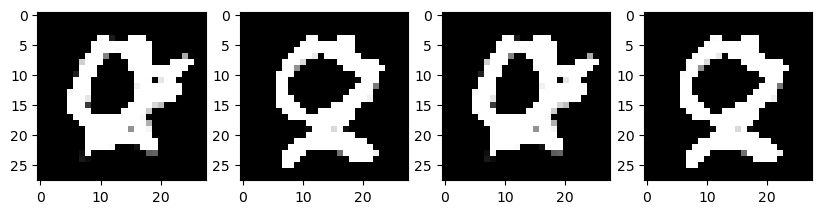

In [145]:
generated_images = generate_samples(gan_model.generator, config, label=0, sample_count=4)
fig, axs = plt.subplots(1, 4, figsize=(10, 8))
axs[0].imshow(generated_images[0,:,:,0], cmap='gray', vmin=0, vmax=1)
axs[1].imshow(generated_images[1,:,:,0], cmap='gray', vmin=0, vmax=1)
axs[2].imshow(generated_images[0,:,:,0], cmap='gray', vmin=0, vmax=1)
axs[3].imshow(generated_images[1,:,:,0], cmap='gray', vmin=0, vmax=1)

In [127]:
def generate_spurious_samples(generator, config, label_1: int, label_2: int, prop_vec: np.array):
    """
    Generates random surrogate elements between two image classes.
    Elements in prop_vec show the contribution of the first image class.
    Return tensor (sample_count, image_size, image_size, 1) of floats in the range [0, 1].
    That is exactly the same format as MNIST dataset is.
    """
    assert len(prop_vec.shape) == 1, "Invalid shape of the proportion vector"
    assert len(generator.input_shape) == 2, "Invalid input shape of the generator model"
    assert generator.input_shape[0] is None, "Invalid input shape of the generator model"
    assert generator.input_shape[1] == config.latent_dim + config.num_classes, "Invalid shape of the generator model"

    sample_count = len(prop_vec)
    generator_noise = keras.random.normal(shape=(sample_count, config.latent_dim))
    label_1 = ops.cast(keras.utils.to_categorical([label_1], config.num_classes), "float32")
    label_2 = ops.cast(keras.utils.to_categorical([label_2], config.num_classes), "float32")

    prop_vec = ops.cast(ops.reshape(prop_vec, (len(prop_vec), 1)), "float32")
    label_tensor = label_1 * prop_vec + label_2 * (1 - prop_vec)
    generator_input = ops.concatenate([generator_noise, label_tensor], 1)
    
    return generator.predict(generator_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


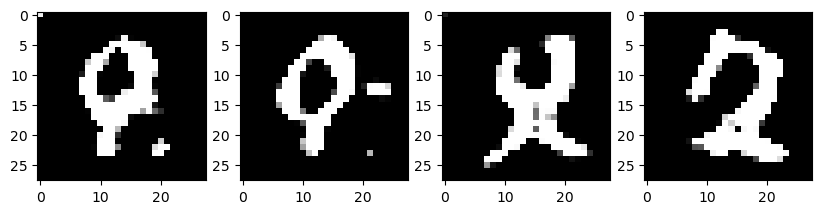

In [147]:
generated_images = generate_spurious_samples(gan_model.generator, config, label_1=0, label_2=1, prop_vec=ops.linspace(0, 1, 4))
fig, axs = plt.subplots(1, 4, figsize=(10, 8))
axs[0].imshow(generated_images[0,:,:,0], cmap='gray', vmin=0, vmax=1)
axs[1].imshow(generated_images[1,:,:,0], cmap='gray', vmin=0, vmax=1)
axs[2].imshow(generated_images[2,:,:,0], cmap='gray', vmin=0, vmax=1)
axs[3].imshow(generated_images[3,:,:,0], cmap='gray', vmin=0, vmax=1)

# IV. Save the model weights

Tactically it is better to save generator and discriminator separately as they are pure `keras` models and do not need infrastructure to restore them.

In [144]:
gan_model.generator.save('models/mnist_gan_generator.keras')
gan_model.discriminator.save('models/mnist_gan_discriminator.keras')